In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [39]:
dataset = pd.read_csv("time_series_covid_19_confirmed.csv")
dataset = pd.DataFrame(dataset)
dataset = dataset.loc[:,:'5/27/20'] # extracting only data upto 27th May
dataset = dataset.groupby(['Country/Region']).sum().reset_index()
countries = dataset['Country/Region'].unique().tolist()
dataset.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,...,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763,763
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61,69,70,70,71


# Finding Realted Countries

In [0]:
#this function returns a country's time series from the day first case was reported
def getTimeSeriesFromDayofFirstRegisteredCase(country,dataset):
  series = dataset[dataset['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return np.trim_zeros(series)  #getting the data from the day of first case reported

#this function returns a country's time series from the day first case was reported
def getTimeSeriesCountry(country,dataset):
  series = dataset[dataset['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return series

def getTimeSeriesTill10thMay(country,dataset):
  dataset1 = dataset.loc[:,:'5/10/20']
  series = dataset1[dataset1['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  return np.trim_zeros(series)

def getCroppedSeriesLength(country,dataset):
  return len(getTimeSeriesFromDayofFirstRegisteredCase(country,dataset))


# takes a dictionary with 6 key value pairs, the value must be the list representing the trend. First key value pair is comapred against rest 5
def printTrends(countriesTrends,title):
  countries = list(countriesTrends.keys())
  print(countries[0],len(countriesTrends[countries[0]]))
  fig,axs = plt.subplots(1,5,figsize=(40,8))
  plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
  fig.suptitle(title, fontsize=16)
  index = 1
  mainTrendLength = len(countriesTrends[countries[0]])
  for i in range (5):
      print(countries[index],len(countriesTrends[countries[index]]))
      data = countriesTrends[countries[index]]
      axs[i].plot(data[:mainTrendLength], label = countries[index])
      axs[i].plot(countriesTrends[countries[0]], label = countries[0])
      axs[i].set_title(countries[index])
      axs[i].legend(loc='upper left')
      index+=1
  for ax in axs.flat:
      ax.set(xlabel='Day', ylabel='Confirmed Cases')

  fig,axs = plt.subplots(figsize=(10,10))
  plt.subplots_adjust(wspace = 0.4,hspace = 0.4)
  fig.suptitle(title, fontsize=16)
  axs.plot(countriesTrends[countries[0]], label = countries[0])
  index = 1
  for i in range (5):
      data = countriesTrends[countries[index]]
      axs.plot(data[:mainTrendLength], label = countries[index])
      axs.set_title(countries[index])
      index+=1
  axs.legend(loc='upper left')
  axs.set(xlabel='Day', ylabel='Confirmed Cases')

def getTop5(values,rev = True):
  top5Countries = list(values.keys())[1:6]
  result = {}
  for x in top5Countries:
    if (x in values.keys()):
      result[x] = values[x]
  result = {k: v for k, v in sorted(result.items(),reverse = rev, key=lambda item: item[1])}
  return result


def getSeries(type,country,dataset):
  if type == 0:
    return getTimeSeriesFromDayofFirstRegisteredCase(country,dataset)
  elif type == 1:
    return getTimeSeriesCountry(country,dataset)
  elif type == 2:
    return getTimeSeriesTill10thMay(country,dataset)
  else:
    return getTimeSeriesFromDayofFirstRegisteredCase(country,dataset)


In [0]:
#0 = getTimeSeriesFromDayofFirstRegisteredCase
#1 = getTimeSeriesCountry
#2 = getTimeSeriesTill10thMay
TYPE1 = 1
TYPE2 = 1
#127 since the beginning of record and until 27th May
#92 since first case and until 27th May
#75 since first case until 10th May
PAKISTAN_SERIES_LENGTH = 127

## Comparing Countries w.r.t Correlation

In [42]:
countries = dataset['Country/Region'].unique().tolist()
pakistanSeries = getSeries(TYPE1,"Pakistan",dataset)
correlations = {}
for country in countries:
  countrySeries = getSeries(TYPE1,country,dataset)
  length = len(countrySeries)
  # if (TYPE1 == 1):
  #   length = getCroppedSeriesLength(country,dataset)
  # else:
  #   length = len(countrySeries)
  rng =  PAKISTAN_SERIES_LENGTH
  if length==0 or length < PAKISTAN_SERIES_LENGTH or ((countrySeries[length-1]) < 1000): #skipping countries with no cases, less than 1000 cases or with length less than pakistan
    continue
  data = np.array([[pakistanSeries[idx] for idx in range(rng)], [countrySeries[idx] for idx in range(rng)]])
  arr = np.corrcoef(data) #finind correlations
  nan_array = np.isnan(arr)
  if (not nan_array[0][1]):
    correlations[country] = list(arr)[0][1]
correlations = {k: v for k, v in sorted(correlations.items(),reverse = True, key=lambda item: item[1])} #sorting countires by correlation
print(correlations)

{'Pakistan': 1.0, 'Saudi Arabia': 0.9989666872972038, 'Qatar': 0.9987397834693381, 'Colombia': 0.9987031556505498, 'Peru': 0.9986075757030275, 'Egypt': 0.9985861314636708, 'Mexico': 0.9982450669084056, 'Senegal': 0.998025386133089, 'Bahrain': 0.9978944531985489, 'Russia': 0.9968814939138532, 'India': 0.9966760504087739, 'Nigeria': 0.9956284812411639, 'Oman': 0.9954593895960144, 'Belarus': 0.9951112860825209, 'Kenya': 0.9946354826740251, 'Congo (Kinshasa)': 0.9945812865322392, 'Kazakhstan': 0.9944083902023374, 'Ghana': 0.9941937077725355, 'South Africa': 0.994085330056083, 'Armenia': 0.9936851387658042, 'Brazil': 0.9935902770017438, 'El Salvador': 0.9930690884499709, 'Honduras': 0.9927880045780964, 'United Arab Emirates': 0.9926906591461169, 'Somalia': 0.9923073748346242, 'Bangladesh': 0.9906254783902331, 'Cameroon': 0.9901830744768644, 'Guinea': 0.9901674423595449, 'Maldives': 0.9899891747317651, 'Equatorial Guinea': 0.9898441941859141, 'Argentina': 0.9894945382852801, 'Chile': 0.98927

In [43]:
# getting only top 5 countries
relationValues = getTop5(correlations,True)
print(relationValues)

{'Saudi Arabia': 0.9989666872972038, 'Qatar': 0.9987397834693381, 'Colombia': 0.9987031556505498, 'Peru': 0.9986075757030275, 'Egypt': 0.9985861314636708}


Pakistan 127
Saudi Arabia 127
Qatar 127
Colombia 127
Peru 127
Egypt 127


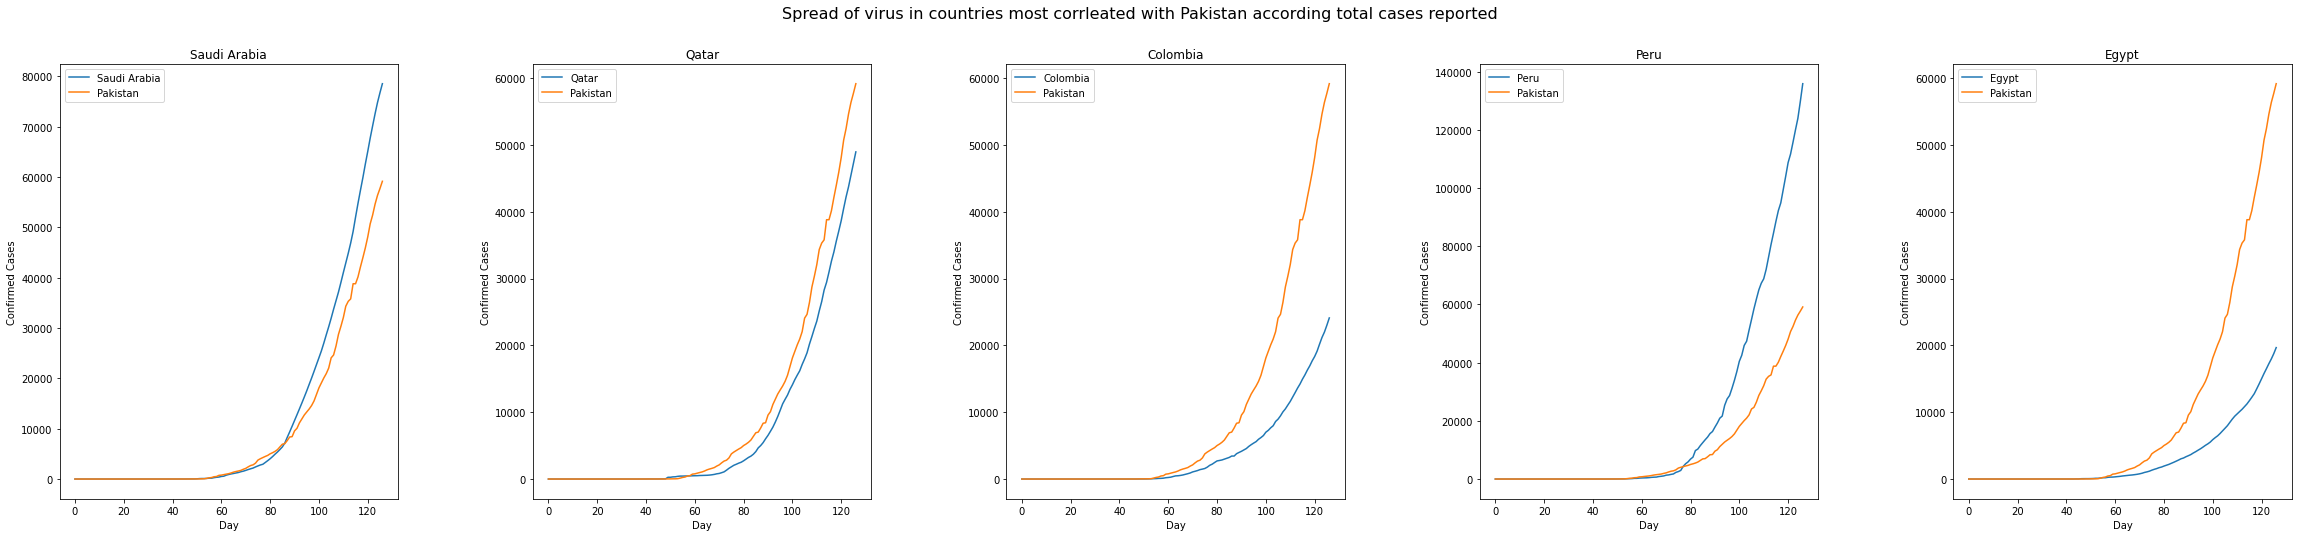

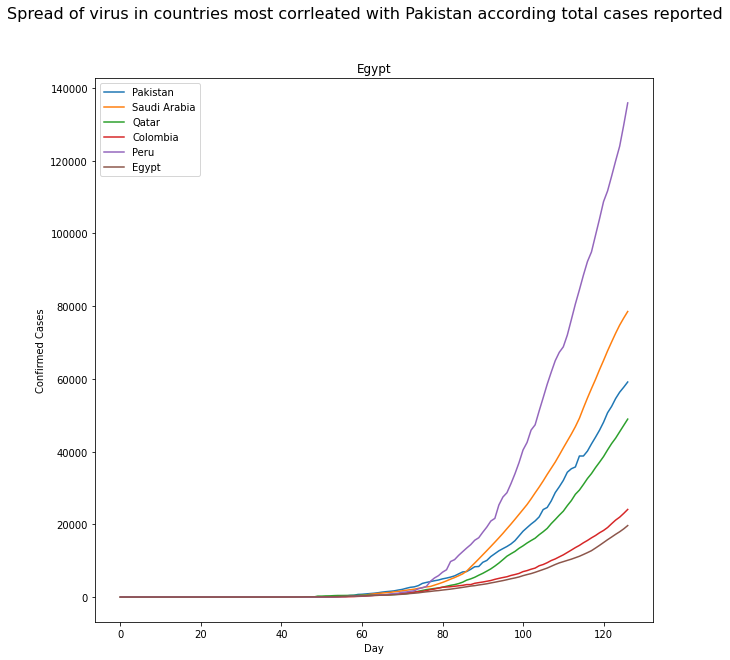

In [44]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE1,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE1,country,dataset)
printTrends(countryTrends,"Spread of virus in countries most corrleated with Pakistan according total cases reported")

## Comparing Countries w.r.t Difference between Cases per day

In [45]:
countries = dataset['Country/Region'].unique().tolist()
pakistanSeries = getSeries(TYPE2,"Pakistan",dataset)
meanDiff = {}
for country in countries:
  countrySeries = getSeries(TYPE2,country,dataset)
  length = len(countrySeries)
  # if (TYPE2 != 2):
  #   length = getCroppedSeriesLength(country,dataset)
  # else:
  #   length = len(countrySeries)
  rng =  PAKISTAN_SERIES_LENGTH
  if length==0 or length < PAKISTAN_SERIES_LENGTH or ((countrySeries[length-1]) < 1000): #skipping countries with no cases, less than 1000 cases or with length less than pakistan
    continue
  dat1 = np.array([pakistanSeries[idx] for idx in range(rng)])
  dat2 = np.array([countrySeries[idx] for idx in range(rng)])
  meanDiff[country] = np.mean(np.abs(dat1 - dat2))
meanDiff = {k: v for k, v in sorted(meanDiff.items(),reverse = False, key=lambda item: item[1])}
print(meanDiff)

{'Pakistan': 0.0, 'Chile': 1487.3149606299212, 'Mexico': 1968.5748031496064, 'Qatar': 2324.5984251968503, 'Ecuador': 2729.6929133858266, 'Singapore': 2891.803149606299, 'Belarus': 2931.1102362204724, 'Saudi Arabia': 3070.220472440945, 'Sweden': 3424.700787401575, 'United Arab Emirates': 3797.7952755905512, 'Ireland': 4150.236220472441, 'Poland': 4446.023622047244, 'Romania': 4786.63779527559, 'Japan': 4874.346456692913, 'Bangladesh': 4878.456692913386, 'Indonesia': 4929.992125984252, 'Portugal': 5000.472440944882, 'Ukraine': 5155.669291338582, 'Israel': 5544.181102362205, 'Philippines': 5952.023622047244, 'Colombia': 5957.346456692913, 'South Africa': 6074.755905511811, 'Denmark': 6211.944881889764, 'Serbia': 6389.456692913386, 'Dominican Republic': 6418.086614173229, 'Austria': 6504.291338582677, 'Egypt': 6649.291338582677, 'Kuwait': 6691.055118110236, 'Czechia': 6782.220472440945, 'Panama': 6938.322834645669, 'Norway': 7101.259842519685, 'Malaysia': 7256.59842519685, 'Australia': 729

In [46]:
#getting only top 5 countires
relationValues = getTop5(meanDiff,False)
print(relationValues)

{'Chile': 1487.3149606299212, 'Mexico': 1968.5748031496064, 'Qatar': 2324.5984251968503, 'Ecuador': 2729.6929133858266, 'Singapore': 2891.803149606299}


Pakistan 127
Chile 127
Mexico 127
Qatar 127
Ecuador 127
Singapore 127


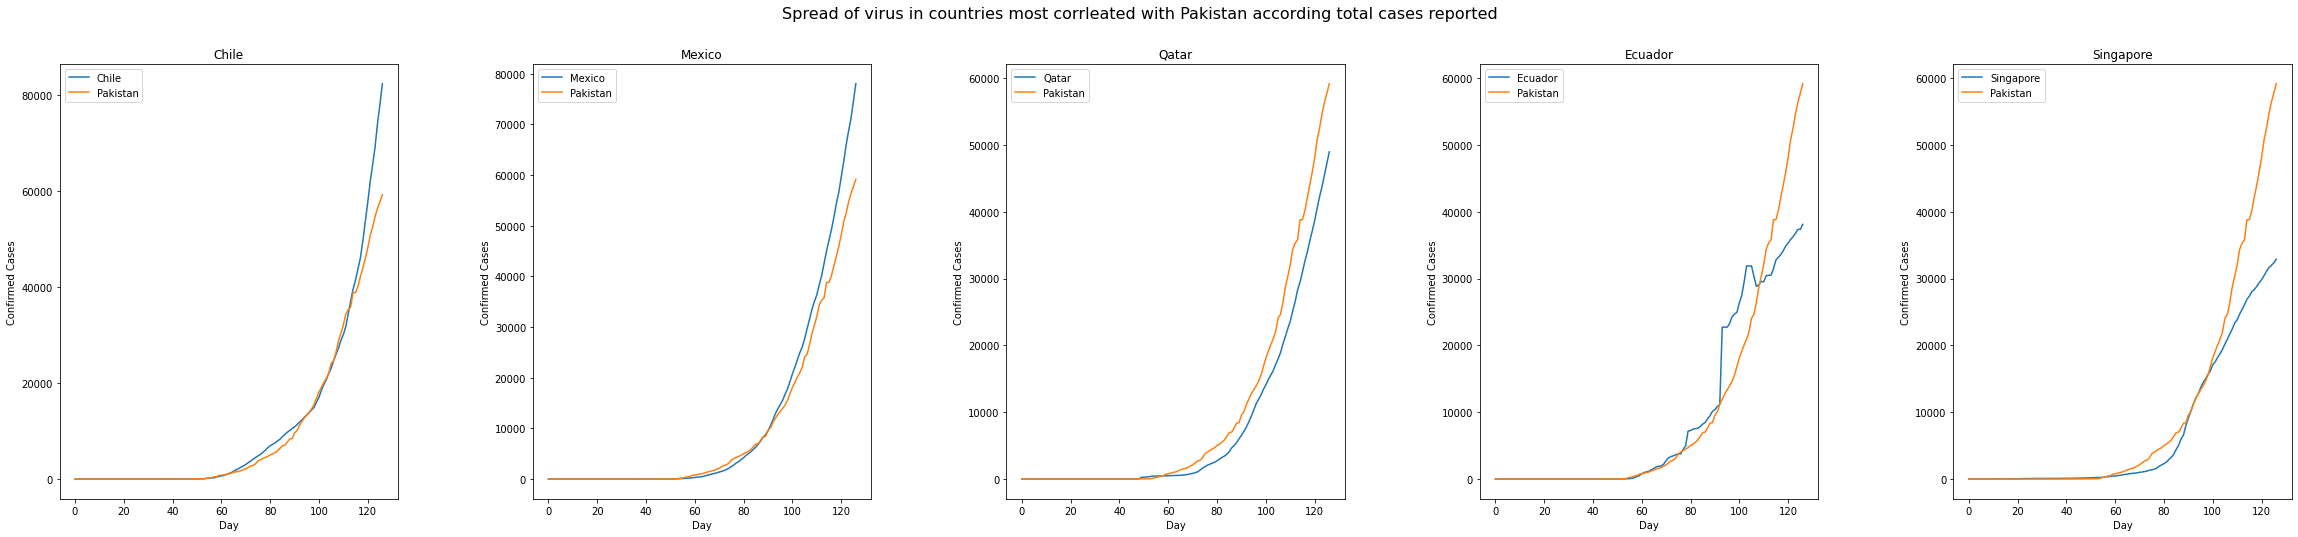

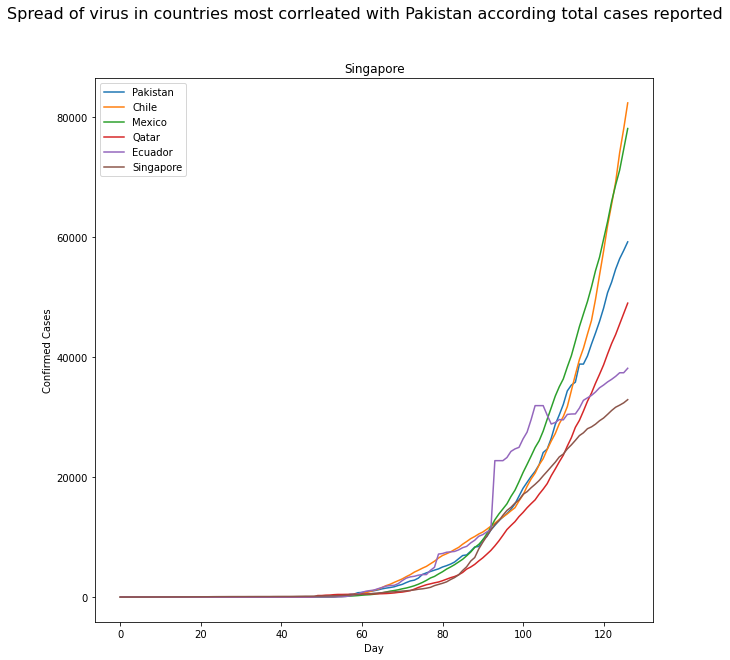

In [47]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE2,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE2,country,dataset)
printTrends(countryTrends,'Spread of virus in countries most corrleated with Pakistan according total cases reported')

## Final Selection based on both criteria

In [48]:
finalValues = {}
trend2 = {}
countries = list(meanDiff.keys())
for country in countries:
  trend2[country] = meanDiff[country]
maximumValue = (max(trend2.values()))
for country in countries:
  trend2[country] = abs(trend2[country] - maximumValue)
trend2 = {k: v for k, v in sorted(trend2.items(),reverse = True, key=lambda item: item[1])}
maximumValue2 = (max(trend2.values()))
for country in countries:
   trend2[country] = trend2[country]/maximumValue2
trend2 = {k: v for k, v in sorted(trend2.items(),reverse = True, key=lambda item: item[1])}
for country in countries:
  finalValues[country] = correlations[country] * 0.5  +  trend2[country] * 0.5
finalValues = {k: v for k, v in sorted(finalValues.items(),reverse = True, key=lambda item: item[1])}
print(finalValues)

{'Pakistan': 1.0, 'Mexico': 0.9969504749042152, 'Qatar': 0.996805008817008, 'Saudi Arabia': 0.9960957666985958, 'Belarus': 0.9943215555992425, 'Chile': 0.9929956658934506, 'Colombia': 0.9927784441623855, 'United Arab Emirates': 0.9921549713066358, 'Egypt': 0.9919564635970219, 'South Africa': 0.9903399857686381, 'Bahrain': 0.9900352089190068, 'Bangladesh': 0.9899300158392992, 'Senegal': 0.988804281125622, 'Nigeria': 0.9883983148091757, 'Oman': 0.9883074615556393, 'Kazakhstan': 0.9881982088626625, 'Ghana': 0.9876463327717082, 'Armenia': 0.9873742640931655, 'Indonesia': 0.9869716707415597, 'Congo (Kinshasa)': 0.9868582045830798, 'Peru': 0.98675623125557, 'Kenya': 0.986748146438282, 'Singapore': 0.9865941794272273, 'Argentina': 0.986490746446705, 'Honduras': 0.9862626348354093, 'Kuwait': 0.986153221190692, 'El Salvador': 0.9860272764746281, 'Somalia': 0.9856568625485193, 'Cameroon': 0.985288173570642, 'Ukraine': 0.9852477718065114, 'Guinea': 0.9849666627327367, 'Afghanistan': 0.98463144602

In [49]:
#getting only top 5 countires
relationValues = getTop5(finalValues,True)
print(relationValues)

{'Mexico': 0.9969504749042152, 'Qatar': 0.996805008817008, 'Saudi Arabia': 0.9960957666985958, 'Belarus': 0.9943215555992425, 'Chile': 0.9929956658934506}


Pakistan 127
Mexico 127
Qatar 127
Saudi Arabia 127
Belarus 127
Chile 127


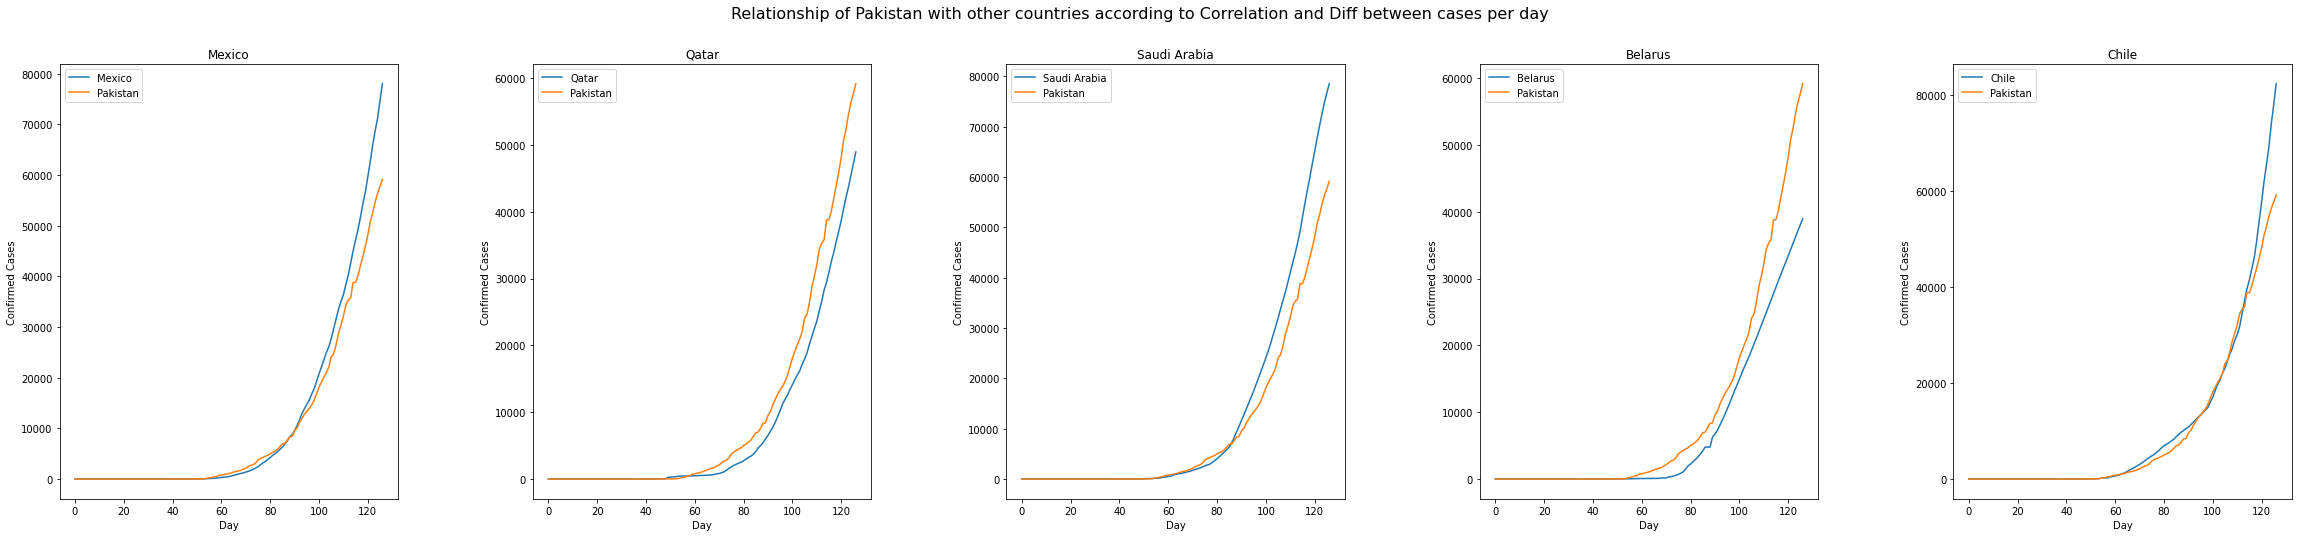

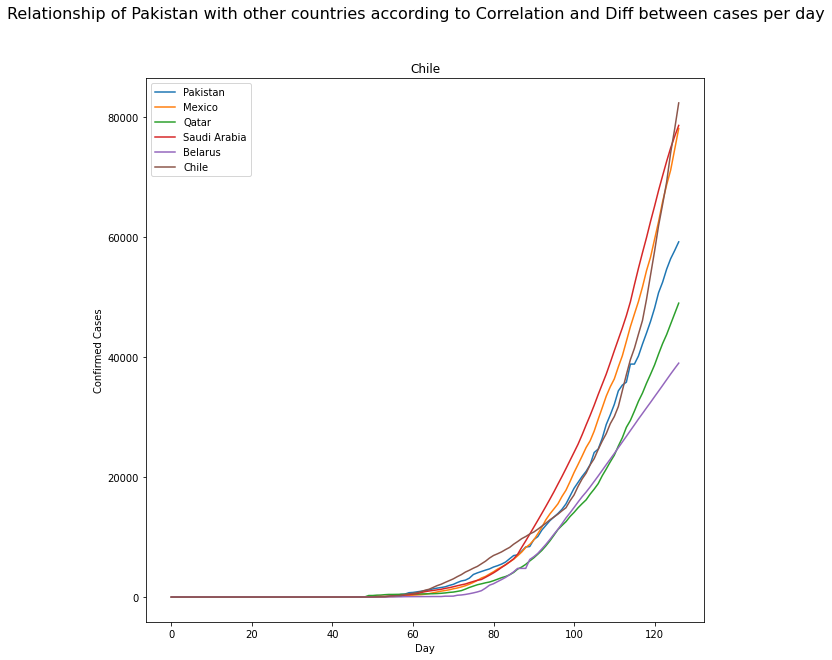

In [50]:
countryTrends = {}
countryTrends["Pakistan"] = getSeries(TYPE2,"Pakistan",dataset)
for country in relationValues.keys():
  countryTrends[country] = getSeries(TYPE2,country,dataset)
printTrends(countryTrends,'Relationship of Pakistan with other countries according to Correlation and Diff between cases per day')

By comparing both approaches we can conclude that correlations give more consistent and stable results, and thus the top 5 realted countries to Pakistan are  
1. Saudi Arabia: 0.9989666872972038  
2. Qatar: 0.9987397834693381  
3. Colombia: 0.9987031556505498  
4. Peru: 0.9986075757030275  
5. Egypt: 0.9985861314636708


# Forecasting

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [52]:
dataset = pd.read_csv("time_series_covid_19_confirmed.csv")
dataset = pd.DataFrame(dataset)
dataset = dataset.loc[:,:'5/27/20'] # extracting only data upto 27th May
dataset = dataset.groupby(['Country/Region']).sum().reset_index()
countries = dataset['Country/Region'].unique().tolist()
dataset.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,...,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763,763
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61,69,70,70,71


In [0]:
def getTimeSeriesTill1Date(country,dataset,date = '5/10/20',crop = True):
  dataset1 = dataset.loc[:,:date]
  series = dataset1[dataset1['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  if (crop):
    return np.trim_zeros(series)
  else:
    return series

def getTimeSeriesTill1Date2(country,dataset,date = '5/10/20',crop = True):
  dataset1 = dataset.loc[:,:date]
  series = dataset1[dataset1['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = series.sum(axis = 0, skipna = True)
  if (crop):
    return np.trim_zeros(series)
  else:
    return series

def convertSeriesToActiveCases(series):
  newSeries = []
  newSeries.append(series[0])
  for i in range(len(series)-1):
    diff = series[i+1] - series[i] 
    newSeries.append(diff)
  return newSeries

def getDailyCaseSeries(country,dataset,date = '5/10/20',crop = True):
  series = getTimeSeriesTill1Date(country,dataset,date,crop)
  return convertSeriesToActiveCases(series)


## ARIMA

In [0]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

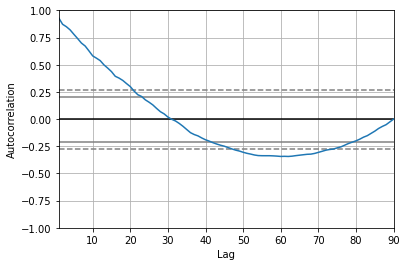

In [55]:
sr = getDailyCaseSeries("Mexico",dataset,date = '5/27/20')
series = DataFrame({'Confirmed':sr})
autocorrelation_plot(series)
pyplot.show()

                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   89
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -598.209
Method:                       css-mle   S.D. of innovations            199.972
Date:                Mon, 08 Jun 2020   AIC                           1210.417
Time:                        15:20:13   BIC                           1227.838
Sample:                             1   HQIC                          1217.439
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                37.0354      8.336      4.443      0.000      20.697      53.374
ar.L1.D.Confirmed    -0.4487      0.106     -4.217      0.000      -0.657      -0.240
ar.L2.D.Confirmed    -0.

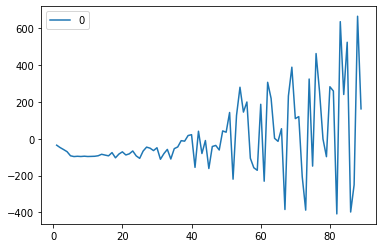

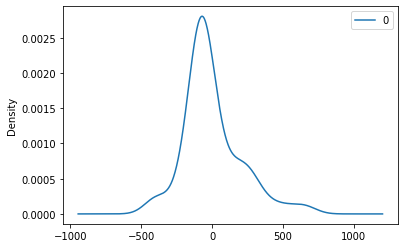

                0
count   89.000000
mean    -1.247009
std    201.151983
min   -408.377046
25%    -95.937245
50%    -58.792694
75%     54.379021
max    665.308453


In [56]:
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [20]:
X = series.values
# size = int(len(X) * 0.66)
size = len(X) - 17
train, test = X[0:size], X[size:len(X)]
# trainDates, testDates = dates[0:size], dates[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(27):
  model = ARIMA(history, order=(3,1,0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  if (t<len(test)):
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
  else:
    history.append(yhat)
    print('Day'+str(t-len(test)+1) +' Future prediction=%f' % yhat)
error = mean_squared_error(test, predictions[:-10])
print('Test RMSE: %.3f' % error**(1/2))

predicted=1684.441674, expected=1305.000000
predicted=1405.531763, expected=1997.000000
predicted=2010.487327, expected=1862.000000
predicted=1758.842682, expected=2409.000000
predicted=2182.866579, expected=2437.000000
predicted=2442.716027, expected=2112.000000
predicted=2184.926978, expected=2075.000000
predicted=2173.639111, expected=2414.000000
predicted=2421.206486, expected=2713.000000
predicted=2632.504727, expected=2248.000000
predicted=2287.385335, expected=2973.000000
predicted=2830.557743, expected=2960.000000
predicted=2900.597084, expected=3329.000000
predicted=3178.391381, expected=2764.000000
predicted=2979.635688, expected=2485.000000
predicted=2653.923729, expected=3455.000000
predicted=3332.558169, expected=3463.000000
Day1 Future prediction=3256.139148
Day2 Future prediction=3199.780982
Day3 Future prediction=3362.702612
Day4 Future prediction=3434.401470
Day5 Future prediction=3433.923885
Day6 Future prediction=3446.407984
Day7 Future prediction=3498.091772
Day8 Fu

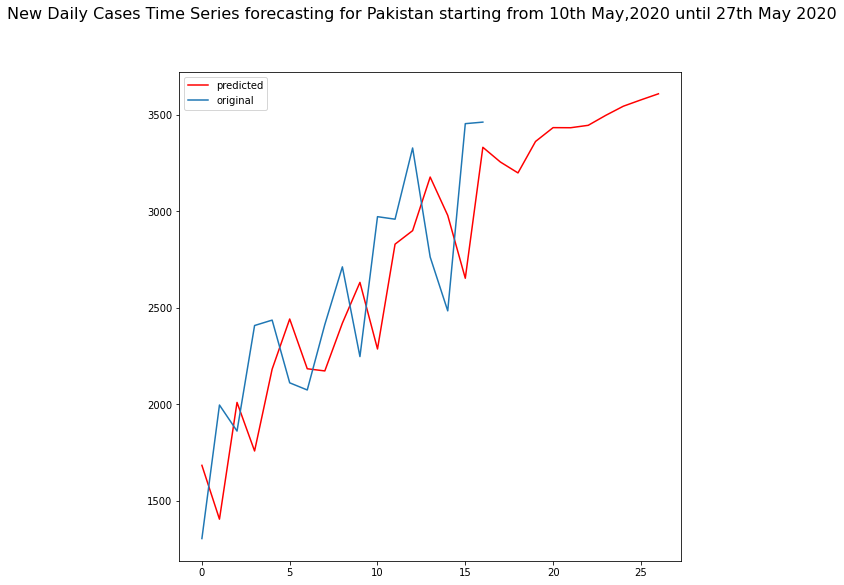

In [21]:
fig,axs = plt.subplots(figsize=(9,9))
fig.suptitle('New Daily Cases Time Series forecasting for Pakistan starting from 10th May,2020 until 27th May 2020', fontsize=16)
axs.plot(predictions, color='red', label = 'predicted')
axs.plot(test, label = 'original')
axs.legend(loc='upper left')
plt.show()

## ARIMA 2


In [0]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

In [0]:
def getTimeSeriesTill1Date(country,dataset,date = '5/10/20',crop = True):
  dataset1 = dataset.loc[:,:date]
  series = dataset1[dataset1['Country/Region'] == country]
  series = series.drop(series.columns[[0, 1, 2]], axis = 1, inplace = False)
  series = np.array(series.sum(axis = 0, skipna = True))
  if (crop):
    return np.trim_zeros(series)
  else:
    return series

def convertSeriesToActiveCases(series):
  newSeries = []
  newSeries.append(series[0])
  for i in range(len(series)-1):
    diff = series[i+1] - series[i] 
    newSeries.append(diff)
  return newSeries

def getDailyCaseSeries(country,dataset,date = '5/10/20',crop = True):
  series = getTimeSeriesTill1Date(country,dataset,date,crop)
  return convertSeriesToActiveCases(series)


### Determining if data is stationary

In [0]:
def getMovingAverage(series,window_size = 7):
  i = 0
  moving_averages = []
  while i < len(series) - window_size + 1:
      this_window = series[i : i + window_size]
      window_average = sum(this_window) / window_size
      moving_averages.append(window_average)
      i += 1
  return moving_averages


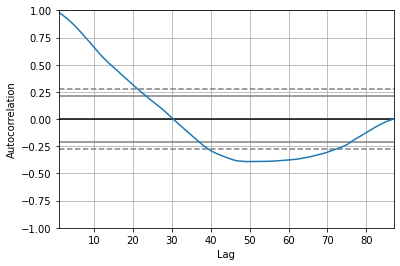

In [25]:
sr = getDailyCaseSeries("Saudi Arabia",dataset,date = '5/27/20')
series = DataFrame({'Daily Cases':sr})
autocorrelation_plot(series)
pyplot.show()

A good starting point for the AR parameter of the model may be 10. This indiactes that for this particular country the previous 10 values are most correlated


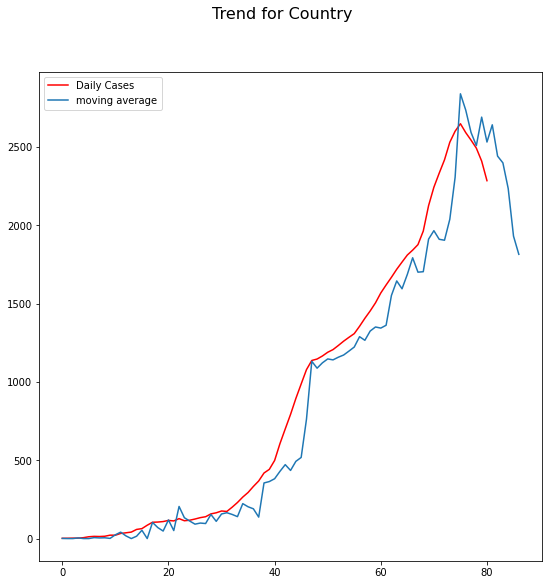

In [26]:
movingAverage = getMovingAverage(sr)
fig,axs = plt.subplots(figsize=(9,9))
fig.suptitle('Trend for Country', fontsize=16)
axs.plot(movingAverage, color='red', label = 'Daily Cases')
axs.plot(sr, label = 'moving average')
axs.legend(loc='upper left')
plt.show()

The graph clearly shows that the trend in not stationary

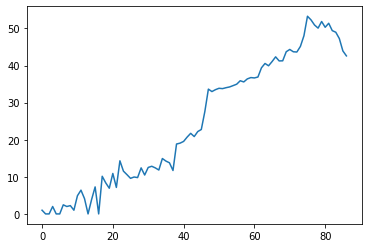

In [27]:
ts_log = np.sqrt(sr)
plt.plot(ts_log)

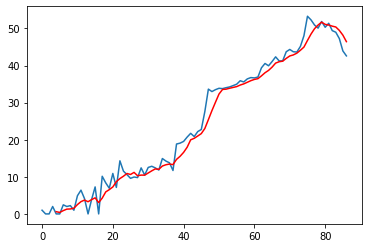

In [28]:
ts_log = DataFrame(ts_log)
moving_avg = ts_log.rolling(5).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [29]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(30)

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,-0.600000
5,-0.400000
6,1.559592
7,0.710102
8,0.898956
9,-0.537112


In [0]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(5).mean()
    rolstd = timeseries.rolling(5).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

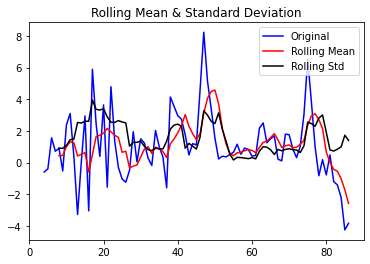

In [31]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

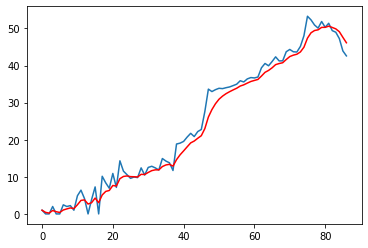

In [32]:
expwighted_avg = ts_log.ewm(halflife=2).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

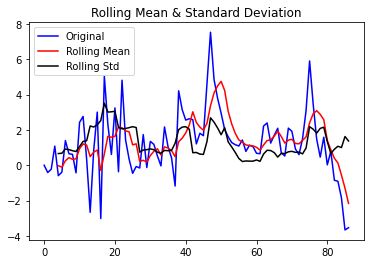

In [33]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

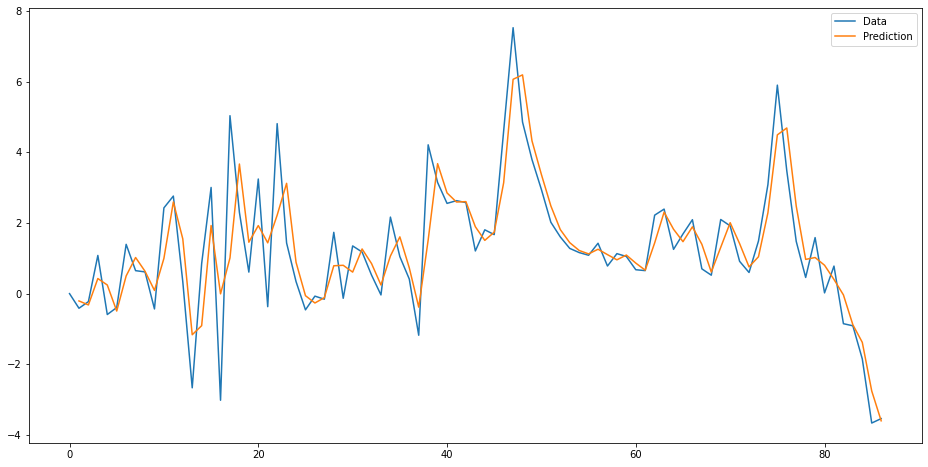

In [34]:
forecast = ts_log_ewma_diff.rolling(2).mean()
# forecast = getMovingAverage(ts_log_ewma_diff.values,2)
plt.figure(figsize=(16,8))
plt.plot(ts_log_ewma_diff, label='Data')
plt.plot(forecast, label='Prediction')
plt.legend(loc='best')
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(ts_log_ewma_diff[5:],forecast[5:]))
print(rms)

1.0181778717322192


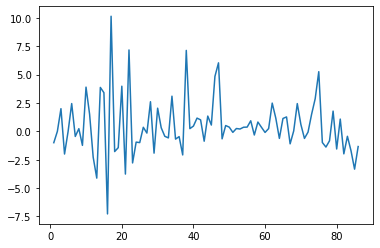

In [36]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

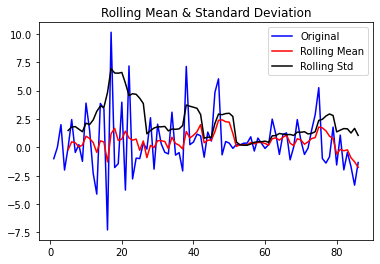

In [37]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## LSTM

In [57]:
import torch
import os
import numpy as np
import pandas as pd
# import seaborn as sns
# from pylab import rcParams
import matplotlib.pyplot as plt
# from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
# from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
# sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
# sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
# rcParams['figure.figsize'] = 14, 10
# register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

2020-02-26    2
2020-02-27    2
2020-02-28    2
2020-02-29    4
2020-03-01    4
dtype: int64

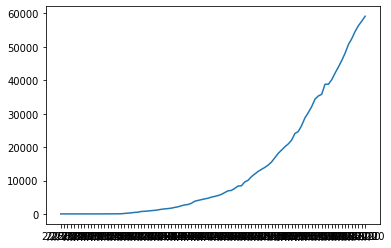

In [115]:
daily_cases = getTimeSeriesTill1Date2("Pakistan",dataset,'5/27/20')
plt.plot(daily_cases)
# df = pd.read_csv('time_series_covid_19_confirmed.csv')
# df = df.iloc[:, 4:]
# daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

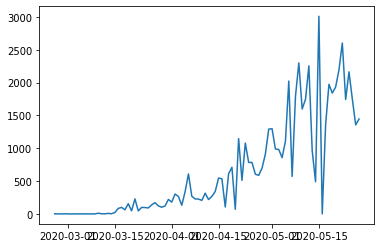

In [116]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()
plt.plot(daily_cases)

In [117]:
test_data_size = 17
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
train_data

(75,)


2020-02-26       2
2020-02-27       0
2020-02-28       0
2020-02-29       2
2020-03-01       0
              ... 
2020-05-06    2024
2020-05-07     571
2020-05-08    1791
2020-05-09    2301
2020-05-10    1598
Length: 75, dtype: int64

In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data = scaler.transform(train_data.values.reshape(-1,1))
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [0]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [0]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [0]:
class CoronaVirusPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [0]:
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')
  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 16
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  for t in range(num_epochs):
    model.reset_hidden_state()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(), y_train)
    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()
      if t % 2 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')
    train_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  return model.eval(), train_hist, test_hist

In [123]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test)

Epoch 0 train loss: 5.890918254852295 test loss: 7.2461323738098145
Epoch 2 train loss: 4.186375617980957 test loss: 2.8812854290008545
Epoch 4 train loss: 3.23068904876709 test loss: 4.342367172241211
Epoch 6 train loss: 3.4421253204345703 test loss: 4.993692398071289
Epoch 8 train loss: 3.390960693359375 test loss: 4.812699317932129
Epoch 10 train loss: 3.2025644779205322 test loss: 4.3402934074401855
Epoch 12 train loss: 3.1463685035705566 test loss: 3.7083544731140137
Epoch 14 train loss: 3.233358383178711 test loss: 3.3512401580810547


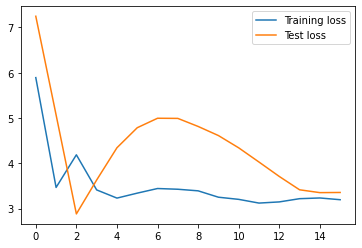

In [124]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend();

In [0]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

[644.62274131 616.91810891 574.50328526 534.64432579 503.00471449
 479.60965271 462.77106044 450.73629414 442.13409095 435.97864889
 431.57372452]
[   0. 1352. 1974. 1841. 1932. 2193. 2603. 1743. 2164. 1748. 1356.]


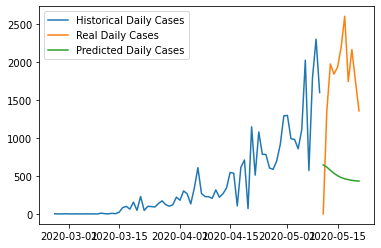

In [127]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)
plt.legend();
print(predicted_cases)
print(true_cases)

In [128]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(92, 1)

In [129]:
X_all, y_all = create_sequences(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 6.370433330535889
Epoch 10 train loss: 3.1473793983459473


In [0]:
DAYS_TO_PREDICT = 30
with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

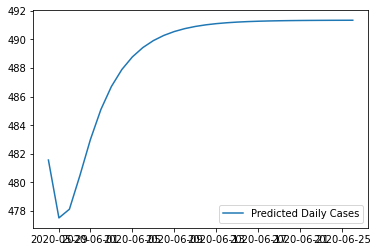

In [133]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();


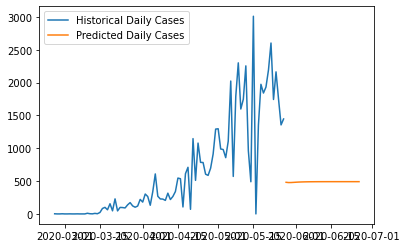

In [134]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [135]:
print(predicted_cases)

2020-05-28    481.561451
2020-05-29    477.514771
2020-05-30    478.122903
2020-05-31    480.479384
2020-06-01    482.994740
2020-06-02    485.097047
2020-06-03    486.703748
2020-06-04    487.895471
2020-06-05    488.775769
2020-06-06    489.428769
2020-06-07    489.915491
2020-06-08    490.279231
2020-06-09    490.551083
2020-06-10    490.754063
2020-06-11    490.905311
2020-06-12    491.018018
2020-06-13    491.101830
2020-06-14    491.164106
2020-06-15    491.210364
2020-06-16    491.244822
2020-06-17    491.270397
2020-06-18    491.289420
2020-06-19    491.303509
2020-06-20    491.313963
2020-06-21    491.321725
2020-06-22    491.327558
2020-06-23    491.331820
2020-06-24    491.335006
2020-06-25    491.337429
2020-06-26    491.339133
Freq: D, dtype: float64


## LSTM Keras

In [136]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset

Using TensorFlow backend.


2020-02-26    2
2020-02-27    2
2020-02-28    2
2020-02-29    4
2020-03-01    4
dtype: int64

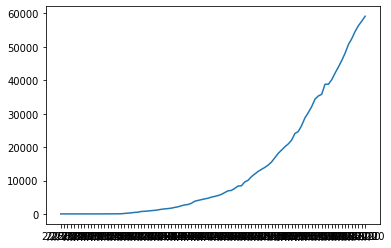

In [137]:
daily_cases = getTimeSeriesTill1Date2("Pakistan",dataset,'5/27/20')
plt.plot(daily_cases)
# df = pd.read_csv('time_series_covid_19_confirmed.csv')
# df = df.iloc[:, 4:]
# daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

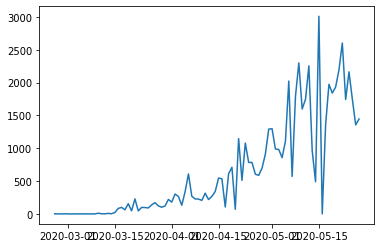

In [138]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()
plt.plot(daily_cases)

In [165]:
test_data_size = 17
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape)
train_data

(75,)


2020-02-26       2
2020-02-27       0
2020-02-28       0
2020-02-29       2
2020-03-01       0
              ... 
2020-05-06    2024
2020-05-07     571
2020-05-08    1791
2020-05-09    2301
2020-05-10    1598
Length: 75, dtype: int64

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train_data.values.reshape(-1,1))
train_data = scaler.transform(train_data.values.reshape(-1,1))
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [173]:
look_back = 5
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
# # reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testX.shape

(69, 5)
(69,)
(11, 5)
(11,)


(11, 1, 5)

In [174]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
 - 1s - loss: 0.0773
Epoch 2/20
 - 0s - loss: 0.0616
Epoch 3/20
 - 0s - loss: 0.0532
Epoch 4/20
 - 0s - loss: 0.0478
Epoch 5/20
 - 0s - loss: 0.0439
Epoch 6/20
 - 0s - loss: 0.0407
Epoch 7/20
 - 0s - loss: 0.0381
Epoch 8/20
 - 0s - loss: 0.0356
Epoch 9/20
 - 0s - loss: 0.0333
Epoch 10/20
 - 0s - loss: 0.0307
Epoch 11/20
 - 0s - loss: 0.0284
Epoch 12/20
 - 0s - loss: 0.0261
Epoch 13/20
 - 0s - loss: 0.0243
Epoch 14/20
 - 0s - loss: 0.0221
Epoch 15/20
 - 0s - loss: 0.0202
Epoch 16/20
 - 0s - loss: 0.0187
Epoch 17/20
 - 0s - loss: 0.0175
Epoch 18/20
 - 0s - loss: 0.0167
Epoch 19/20
 - 0s - loss: 0.0159
Epoch 20/20
 - 0s - loss: 0.0150


In [179]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 275.62 RMSE
Test Score: 723.17 RMSE


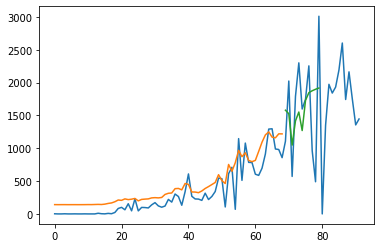

In [215]:
# shift train predictions for plotting
trainPredictPlot = numpy.zeros(daily_cases.values.shape)
# trainPredictPlot[:,:] = numpy.nan
# trainPredictPlot[0:len(trainPredict),:] = trainPredict
trainPredictPlot = trainPredict.flatten()
# shift test predictions for plotting
testPredictPlot = numpy.empty(daily_cases.values.shape)
testPredictPlot[:] = numpy.NaN
testPredictPlot[len(trainPredict):len(trainPredict)+11] = testPredict.flatten()
# plot baseline and predictions
plt.plot(daily_cases.values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()